In [42]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import sys

from collections import defaultdict

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

sys.path.insert(0, '../python/')
from helpers import *

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings('ignore')

# Feature Importance

In [17]:
# features
# - hotel: [Resort Hotel, City Hotel] => [0, 1]
# - total_nights: [1, 2, 3, 4, 5, 6, 7, 8] => dummies
# - total_special_requests: [0, 1, 2] => dummies
# - market_segment: [Corporate, Online TA, Offline TA/TO, Direct, Groups] => dummies
# - room_difference: [0, 1]
# - party_size: [1, 2, 3] => dummies
# - booking_changes: [0, 1]

In [26]:
data = pd.read_csv('../../data/train/cancellations.csv')

feats = ['hotel','market_segment', 'total_of_special_requests', 
         'total_nights', 'room_difference', 'party_size', 'booking_changes']
dummy_cols = ['total_nights', 'total_of_special_requests', 'market_segment', 'party_size']

X = data[feats].copy()

X.replace(['Resort Hotel', 'City Hotel'], [0, 1], inplace=True)
X.loc[np.argwhere((X['total_nights'] >= 8).values).flatten(), 'total_nights'] = 8
X.loc[np.argwhere((X['total_of_special_requests'] >= 2).values).flatten(), 'total_of_special_requests'] = 2
X.loc[np.argwhere(X['market_segment'].isin(['Aviation', 'Complementary']).values).flatten(), 'market_segment'] = 'Corporate'
X.loc[np.argwhere((X['party_size'] >= 3).values).flatten(), 'party_size'] = 3
X.loc[np.argwhere((X['booking_changes'] >= 1).values).flatten(), 'booking_changes'] = 1

X = pd.get_dummies(X, columns=dummy_cols)

X_train = X.to_numpy()
y_train = data[['is_canceled']].to_numpy()

In [27]:
best_rf_model = RandomForestClassifier(criterion='gini', max_depth=3, 
                                      max_features='sqrt', n_estimators=200, 
                                      min_samples_leaf=1)

best_gb_model = GradientBoostingClassifier(loss='deviance', 
                                           max_depth=3, 
                                           max_features=None, 
                                           n_estimators=300,
                                           min_samples_leaf=1, 
                                           learning_rate=0.01)
log_reg = LogisticRegression()

In [28]:
best_rf_model.fit(X_train, y_train)
best_gb_model.fit(X_train, y_train)
log_reg.fit(X_train, y_train)

LogisticRegression()

## Mean Decrease Impurity

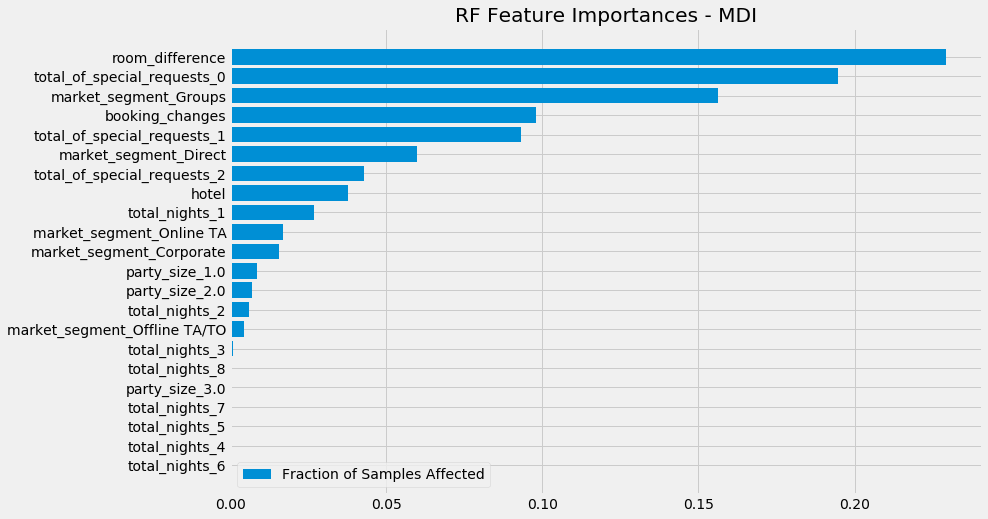

In [39]:
feat_scores = pd.DataFrame({'mdi' : best_rf_model.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='mdi')


fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(feat_scores.index, feat_scores.mdi, label='Fraction of Samples Affected')
ax.set_title('RF Feature Importances - MDI')
ax.legend()

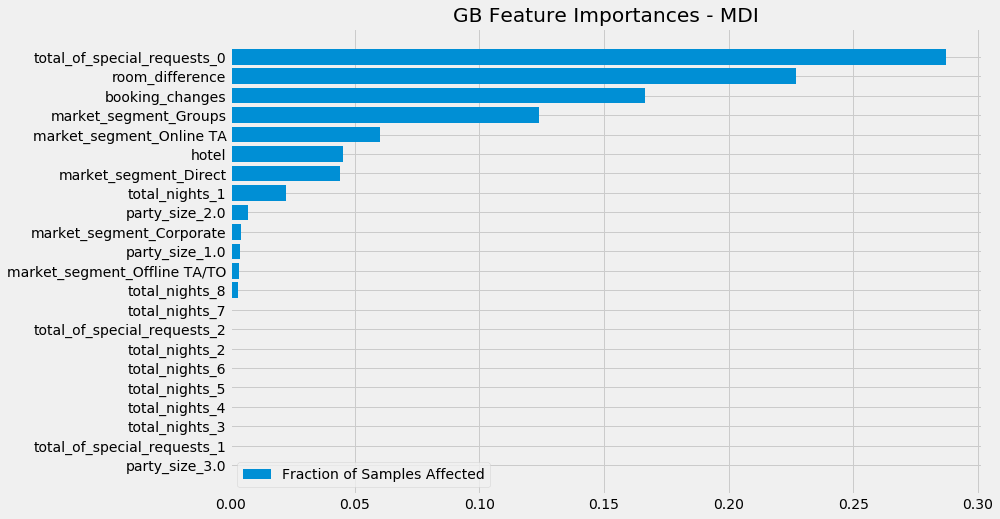

In [40]:
feat_scores = pd.DataFrame({'mdi' : best_gb_model.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='mdi')


fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(feat_scores.index, feat_scores.mdi, label='Fraction of Samples Affected')
ax.set_title('GB Feature Importances - MDI')
ax.legend()

## Mean Decrease Accuracy

In [88]:
def mda(model, X, y, n_iter=4):
    scores = defaultdict(list)
    cols = X.shape[1]
    
    cols = 4
    accuracies = []
    
    splitter = ShuffleSplit(n_iter, test_size=0.3)
    for i, (train_idx, test_idx) in enumerate(splitter.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))
        
        print(acc)
        shuffle_scores = []
        for col in range(cols):
            X_train_copy = X_train.copy()
            np.random.shuffle(X_train_copy[:, col])

            model.fit(X_train_copy, y_train)

            shuffle_acc = accuracy_score(y_test, model.predict(X_test))
            print(shuffle_acc)
            shuffle_scores.append((acc-shuffle_acc)/acc)
            print(shuffle_scores)
            
        accuracies.append(np.array(shuffle_scores))
        
    return np.array(accuracies)

In [89]:
accuracies = mda(best_rf_model, X_train, y_train)

0.6268656716417911
0.6268656716417911
[0.0]
0.6268656716417911
[0.0, 0.0]
0.6268656716417911
[0.0, 0.0, 0.0]


KeyboardInterrupt: 

In [ ]:
accuracies

# Profit Curves

In [44]:
X.shape

(94470, 22)

In [47]:
np.random.shuffle?

In [49]:
np.zeros((4, 5))

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])